# Osyczka and Kundu function multi-objective optimization (min).
---
Description:

- Optimization (min)
- Multi-objective (2)
- Constraints (6)
---

Minimize the equations given by:

\begin{cases}
      f_{1}\left(\mathbf{x}\right) = -(25(x_1 - 2)^2 + (x_2 - 2)^2 + (x_3 - 1)^2 + (x_4 - 4)^2 + (x_5 - 1)^2), \\
      f_{2}\left(\mathbf{x}\right) = x_1^2 + x_2^2 + x_3^2 + x_4^2 + x_5^2 + x_6^2, \\
\end{cases}

subject to:

\begin{cases}
      C_{1}\left(\mathbf{x}\right) = (x_1 + x_2 − 2) \geq 0, \\
      C_{2}\left(\mathbf{x}\right) = (6 - x_1 − x_2) \geq 0, \\
      C_{3}\left(\mathbf{x}\right) = (2 - x_2 + x_1) \geq 0, \\
      C_{4}\left(\mathbf{x}\right) = (2 − x_1 + 3x_2) \geq 0, \\
      C_{5}\left(\mathbf{x}\right) = (4 − (x_3 − 3)2 − x_4) \geq 0, \\
      C_{6}\left(\mathbf{x}\right) = ((x_5 − 3)^2 + x_6−4) \geq 0, \\
\end{cases}

where:

\begin{cases}
      0\le x_1, x_2, x_6 \le 10, \\
      1\le x_3, x_5 \le 5, \\
      0\le x_4 \le 6. \\
\end{cases}

The Pareto-optimal region is a concatenation of five regions. Every region lies on some of the constraints. However, for the entire Pareto-optimal region, $\hat{x}_4=\hat{x}_6=0$.

### First we import python libraries and set up the directory of our code.

In [1]:
import os, sys
import numpy as np
from math import fsum
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [2]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.engines.island_model_ga import IslandModelGA
from pygenalgo.engines.auxiliary import pareto_front, cost_function

# Import Selection Operator(s).
from pygenalgo.operators.selection.tournament_selector import TournamentSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.random_mutator import RandomMutator

# Import Migration Operator(s).
from pygenalgo.operators.migration.clockwise_migration import ClockwiseMigration

### Define the multi-objective function, which plays also the role of the 'fitness' function.

In addition, we define a 'boundary_x', for each variable, which takes the role of the 'random()' method
of the Genes, using the required range.

In [3]:
# Multi-objective function.
@cost_function(minimize=True)
def fun_OSY(individual: Chromosome):
    
    # Set the penalty coefficient.
    rho = 80.0
    
    # Extract the gene values.
    x1, x2, x3, x4, x5, x6 = individual.values()
        
    # Compute each objective function.
    f1 = -(25.0*(x1 - 2.0)**2 +
                (x2 - 2.0)**2 +
                (x3 - 1.0)**2 +
                (x4 - 4.0)**2 +
                (x5 - 1.0)**2)
    
    f2 = fsum(([x1**2, x2**2, x3**2, x4**2, x5**2, x6**2]))
    
    # Compute the constraints.
    C1 = min(0.0, (x1 + x2 - 2.0))**2
    C2 = min(0.0, (6.0 - x1 - x2))**2
    C3 = min(0.0, (2.0 + x1 - x2))**2
    C4 = min(0.0, (2.0 - x1 + 3.0*x2))**2
    C5 = min(0.0, (4.0 - (x3 - 3.0)**2 - x4))**2
    C6 = min(0.0, ((x5 - 3.0)**2 + x6 - 4.0))**2
    
    # Compute the final value.
    f_value = fsum([0.1*f1, 0.9*f2, rho*(C1 + C2 + C3 + C4 + C5 + C6)])
    
    # Return the solution.
    return f_value
# _end_def_

# Random number generator.
rng = np.random.default_rng()

# Random boundary functions (one for each variable):
boundary_x1 = lambda: rng.uniform(0.0, 10.0)
boundary_x2 = lambda: rng.uniform(0.0, 10.0)
boundary_x3 = lambda: rng.uniform(1.0,  5.0)
boundary_x4 = lambda: rng.uniform(0.0,  6.0)
boundary_x5 = lambda: rng.uniform(1.0,  5.0)
boundary_x6 = lambda: rng.uniform(0.0, 10.0)

Here we set the GA parameters, such as number of genes, number of chromosomes, etc. Note that in this case each gene has different random() function, because they are valid in different ranges according to the 
problem definition.

In [4]:
# Define the number of chromosomes.
N = 200

# Initial population.
population = [Chromosome([Gene(rng.uniform(0.0, 10.0), boundary_x1),
                          Gene(rng.uniform(0.0, 10.0), boundary_x2),
                          Gene(rng.uniform(1.0,  5.0), boundary_x3),
                          Gene(rng.uniform(0.0,  6.0), boundary_x4),
                          Gene(rng.uniform(1.0,  5.0), boundary_x5),
                          Gene(rng.uniform(0.0, 10.0), boundary_x6)], np.nan, True)
              for _ in range(N)]

# Create the IslandModelGA object that will carry on the optimization.
test_GA = IslandModelGA(initial_pop=population,
                        fit_func=fun_OSY, num_islands=4,
                        select_op=TournamentSelector(),
                        mutate_op=RandomMutator(),
                        crossx_op=UniformCrossover(),
                        migrate_op=ClockwiseMigration())

### Optimization process.

Here we call the GA object (either directly, or through the method run()). We set a number of parameter, such as the maximum iterations (i.e. epochs), tolerance for the fitness convergences, etc.

In [5]:
test_GA(epochs=2500, elitism=True, f_tol=1.0e-8, allow_migration=True, adapt_probs=True)

Parallel evolution in progress with 4 islands ...
Final Avg. Fitness = -344.8687.
Elapsed time: 36.356 seconds.


In [6]:
# Extract the gene values.
x = test_GA.best_chromosome().values()

# Compute each objective function.
f1_opt = -(25.0*(x[0] - 2.0)**2 +
                (x[1] - 2.0)**2 +
                (x[2] - 1.0)**2 +
                (x[3] - 4.0)**2 +
                (x[4] - 1.0)**2)

f2_opt = fsum([i**2 for i in x])

for i, xi in enumerate(x, start=1):
    print(f"x{i}={xi:.5f}")

print(" ")
print(f"f1(x) = {f1_opt:.5f}")
print(f"f2(x) = {f2_opt:.5f}")

x1=0.00180
x2=1.97686
x3=1.00041
x4=0.00062
x5=1.00041
x6=0.00575
 
f1(x) = -115.81546
f2(x) = 5.90965


### Compute the Pareto Frontier (solutions).

In [7]:
# Create a list that will hold points that satisfy both constraints.
points = []

L = 30

x4, x6 = 0.0, 0.0

# Test some grid points.
for x1 in np.linspace(0.0, 10.0, L):
    
    for x2 in np.linspace(0.0, 10.0, L):
        
        for x3 in np.linspace(1.0, 5.0, L):
            
            for x5 in np.linspace(1.0, 5.0, L):
                
                # Compute the constraints.
                C1 = (x1 + x2 - 2.0) >= 0.0
                C2 = (6.0 - x1 - x2) >= 0.0
                C3 = (2.0 - x2 + x1) >= 0.0
                C4 = (2.0 - x1 + 3.0*x2) >= 0.0
                C5 = (4.0 - (x3 - 3.0)**2 - x4) >= 0.0
                C6 = ((x5 - 3.0)**2 + x6 - 4.0) >= 0.0
                
                # If all constraints are satisfied.
                if all([C1, C2, C3, C4, C5, C6]):
                    
                    # Evaluate both functions.
                    f1 = -(25.0*(x1 - 2.0)**2 +\
                                (x2 - 2.0)**2 +\
                                (x3 - 1.0)**2 +\
                                (x4 - 4.0)**2 +\
                                (x5 - 1.0)**2)

                    f2 = fsum([i**2 for i in (x1, x2, x3, x4, x5, x6)])

                    # Keep the point in the list.
                    points.append((f1, f2))
                # _end_if_
# _end_for_

# Estimate the pareto front points.
pareto_points = pareto_front(points)

# Convert list to numpy.
pareto_points = np.array(pareto_points)

### Visualize the solution on the Pareto plot.

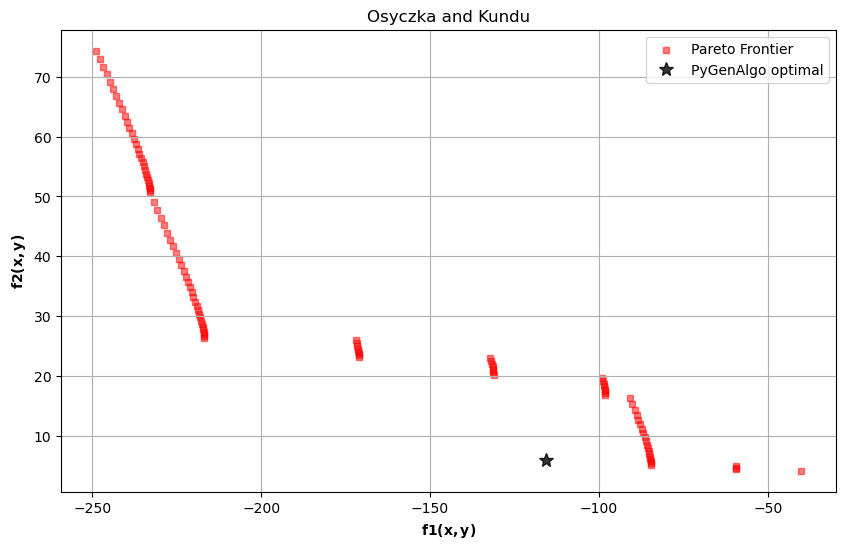

In [8]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.scatter(x=pareto_points[:, 0],
            y=pareto_points[:, 1],
            s=20, marker='s', color='red', alpha=0.5, label="Pareto Frontier")

# Plot the optimal solution from the GA.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="PyGenAlgo optimal")

# Tidy up the plot.
plt.title("Osyczka and Kundu")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Osyczka_and_Kundu_optimal.pdf", format="pdf", dpi=300)

### End of file